In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from gee_scripts.parameters import explain_vars, response_var
from gee_scripts.randomforest import bootstrap
from scipy.stats import pearsonr
from gee_scripts.plots import get_precipitation_plot
from gee_scripts.randomforest import get_regressor

# 1. Read training data

In [65]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
assert df[["date"]].dtypes.iloc[0] == "datetime64[ns]"

In [70]:
df.phu_id.unique()

array([407.,  nan, 404., 375., 256., 340.,  24.,  19., 114.,  99., 120.,
        71., 119.,  89., 188., 352., 371., 424., 443., 544., 171., 169.,
       115.,  65., 146., 149., 150., 154., 152., 314., 297., 253., 229.,
       239., 219., 308., 370., 356., 350., 361., 351., 357., 381., 379.,
       382., 847.])

In [67]:
filter_condition = df.phu_id==835
train_df = df[filter_condition]
len(train_df)

0

In [46]:
# # get a boxplot of response var per region but use a small graph size

# # set the seaborn style and size
# sns.set_style("whitegrid");
# sns.set(rc={'figure.figsize':(8,5)});
# sns.boxplot(x="region_id", y="gwl_cm", data=train_df, width=0.5);

In [47]:
# # Get a table with the count of the number of observations per month
# train_df["month"] = train_df["date"].dt.month
# train_df["year"] = train_df["date"].dt.year
# train_df["month_year"] = train_df["date"].dt.to_period('M')
# train_df[train_df.id == "15_RAPP_LGBI-001a"].groupby("month_year").size().reset_index(name='counts')

len(df) 128


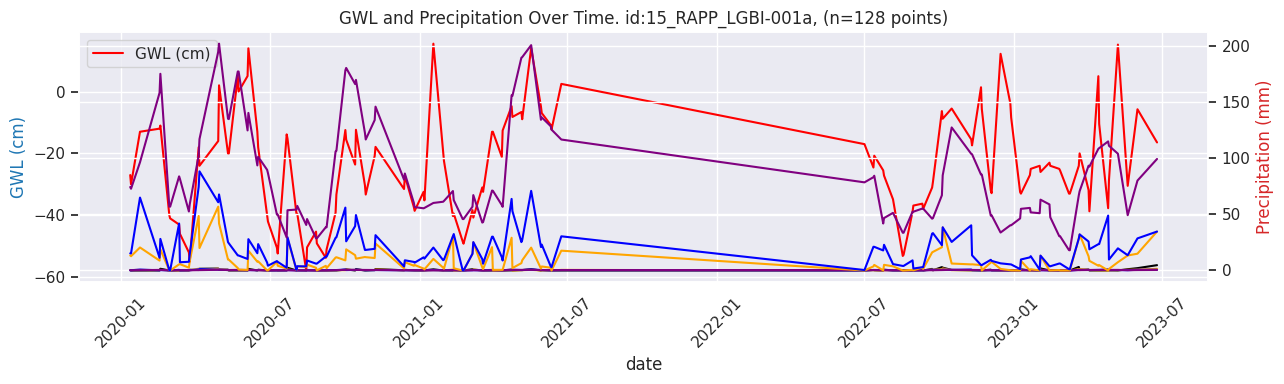

In [49]:
# train_df["date"] = pd.to_datetime(train_df["date"])
get_precipitation_plot(train_df, group_by="station", value="15_RAPP_LGBI-001a")

In [63]:
# group by id and get the number of dates for each id
group_by = "id"
df_grouped = train_df.groupby(group_by).count().reset_index()
df_grouped = df_grouped[[group_by, "date"]]
df_grouped.columns = ["name", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False);

In [53]:
# drop all stations with less tan 9 observations
min_obs = 0
train_df.groupby('id').agg({'date': 'count'}).sort_values(by='date', ascending=False).reset_index()
train_df = train_df.groupby('id').filter(lambda group: len(group) >= min_obs)

In [54]:
# split the training_df into training and test where test is the last year

train_data = train_df[train_df["date"].dt.year <= 2022]
test_data = train_df[train_df["date"].dt.year > 2022]

X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))


lenght of train and test 367 55


In [55]:
regr = get_regressor()

r2_score: 0.05550961297469881
rmse: 14.89417664293703
pearson r: 0.31848413901117667
p-value: 0.017799593631709975


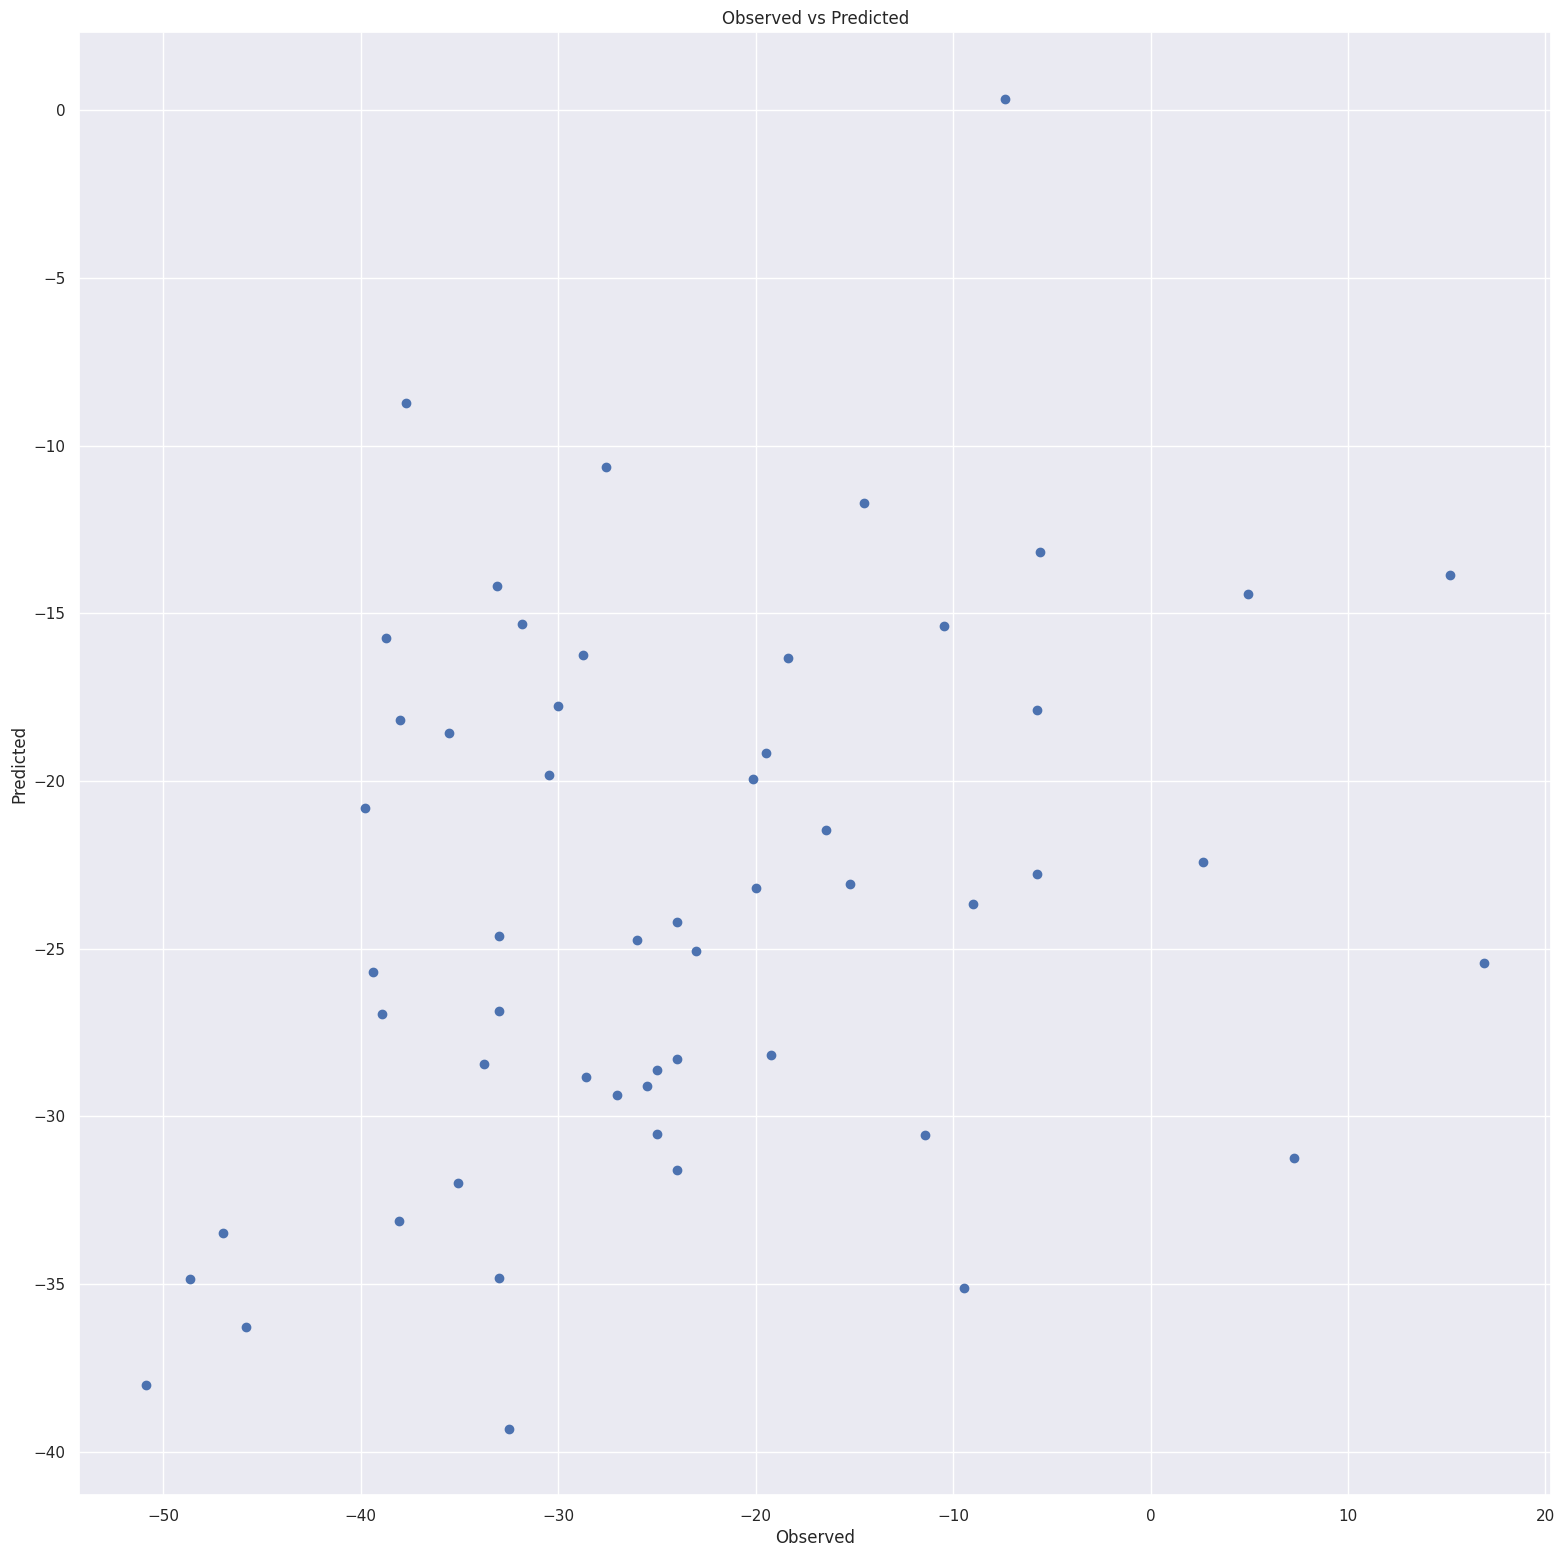

In [62]:

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

# Plot the observed vs predicted with labels and title
plt.scatter(y_test, y_pred_test)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted")
plt.show()

In [ ]:
rmse


In [ ]:

print("dependent var", response_var)
print("explanatory lenght", len(explain_vars))
print(explain_vars)

In [ ]:
# bootstrap_result = bootstrap(df = train_df, variable="gwl_cm", iterations=100, train_size=0.8, explain_vars=explain_vars, bootstrap_by="observations")
# bootstrap_result

In [ ]:
# Now I want to test the model on unseen data and see how it performs
from gee_scripts.randomforest import get_regressor

# train the model on all the data
regressor = get_regressor()
regressor.fit(train_df[explain_vars], train_df['gwl_cm'])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 350, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Assume get_regressor() is your function to get the base model
base_model = get_regressor()
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
X_train, y_train = df[explain_vars], df['gwl_cm']
grid_search.fit(X_train, y_train)

In [ ]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
# Test on unseen data
test_df = df[df.phu_id == 169]
# test_df

In [ ]:

X_test, y_test = test_df[explain_vars], test_df['gwl_cm']

y_pred = regressor.predict(X_test)
r, p = pearsonr(y_test, y_pred)
r


In [ ]:
r2_score(y_test, y_pred)

In [ ]:
test_df

In [ ]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

In [ ]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred}).plot.scatter(x="y_test", y="y_pred")

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

